<a href="https://colab.research.google.com/github/Jaydenzk/DS-repo/blob/master/Post_here_subreddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import math

In [2]:
PAGE_COUNT = 5
RANDOM_STATE = 0
TEST_SIZE = 0.25

def get_reddit_data(page_count):
    print('fetching your data, * = 1 request to the Reddit API')
    headers = {'User-Agent': 'Predicting Reddit Post Metadata'}
    posts = []
    top_subreddits = [ 'r/funny', 'r/gaming', 'r/pics',
            'r/aww', 'r/science', 'r/worldnews', 'r/Music',
            'r/movies', 'r/todayilearned', 'r/videos'
    ]
    for i in range(len(top_subreddits)):
        after = ''
        for j in range(page_count):
            print('*', end='')
            url = 'https://www.reddit.com/'+ top_subreddits[i] + '/top.json?t=all&after=' + after
            #print(url)
            response = requests.get(url, headers=headers)    
            for k in range(len(response.json()['data']['children'])):
                post = {}
                post['created_utc'] = int(response.json()['data']['children'][k]['data']['created_utc'])
                post['is_video'] = int(response.json()['data']['children'][k]['data']['is_video'])
                post['subreddit'] = response.json()['data']['children'][k]['data']['subreddit']
                post['title'] = response.json()['data']['children'][k]['data']['title']
                post['total_awards_received'] = response.json()['data']['children'][k]['data']['total_awards_received']
                post['ups'] = response.json()['data']['children'][k]['data']['ups']
                posts.append(post)
            after = response.json()['data']['after']    
    return posts

columns = ['created_utc', 'is_video', 'subreddit', 'title', 'total_awards_received', 'ups']
df = pd.DataFrame(get_reddit_data(PAGE_COUNT), columns=columns)
df = df.sample(frac=1, random_state=RANDOM_STATE)

fetching your data, * = 1 request to the Reddit API
**************************************************

In [3]:
print('df.Describe():\n', df.describe(), '\n')
print(df.info(), '\n')
print('df.head(10):\n', df.head(10), '\n')
print('SUM OF NA VALUES:\n', df.isna().sum(), '\n')

df.Describe():
         created_utc     is_video  total_awards_received            ups
count  1.250000e+03  1250.000000             1250.00000    1250.000000
mean   1.536007e+09     0.058400                8.51600  111915.628000
std    2.822121e+07     0.234592               30.55932   41492.555851
min    1.407798e+09     0.000000                0.00000   35406.000000
25%    1.514150e+09     0.000000                0.00000   77573.000000
50%    1.539458e+09     0.000000                2.00000  111618.500000
75%    1.557992e+09     0.000000                7.00000  138394.750000
max    1.580818e+09     1.000000              521.00000  349290.000000 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 711 to 684
Data columns (total 6 columns):
created_utc              1250 non-null int64
is_video                 1250 non-null int64
subreddit                1250 non-null object
title                    1250 non-null object
total_awards_received    1250 non-null int64
ups      

In [38]:
df.head(25)

,created_utc,is_video,subreddit,title,total_awards_received,ups
711,1511202915,0,worldnews,Pope Francis denounces climate change deniers,1,98794
898,1563793522,0,movies,James Cameron congratulates Avengers: Endgame ...,2,96194
186,1541352571,0,gaming,Steve Jobs said it first,7,129248
867,1501167461,0,Music,Steve Earle says modern country stars make 'hi...,0,36523
18,1548784436,0,funny,"Citizen of Golden, CO (home of Coors and about...",6,170712
1152,1562593061,0,videos,Let's not forget about the teacher who was arr...,6,101421
192,1529623801,0,gaming,"Youtuber ""Potates"" completely plagiarized a po...",10,127320
184,1479762343,0,gaming,Some Michael Bay shit going on right here,0,129572
824,1551698540,0,Music,Prodigy frontman Keith Flint found dead at his...,3,44639
1058,1519147317,0,todayilearned,TIL there's a restaurant in New York that does...,1,105331


In [60]:
df.shape

(1250, 6)

In [0]:
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score

In [62]:
def train_predict_report(tprdf, print_info=True):
    X = tprdf['title'].values
    y = tprdf['subreddit'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=0)
    model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    model.fit(X_train, y_train);
    y_predict = model.predict(X_test)
    accuracy = (y_predict == y_test).mean()
    baseline = pd.Series(y_test).value_counts()[0] / pd.Series(y_test).value_counts().sum()
    prediction_count = pd.Series(y_test).value_counts().sum()
    if (print_info):
        print('VC of y_train')
        print(pd.Series(y_train).value_counts()[:10], '\n')
        print('VC of y_test')
        print(pd.Series(y_test).value_counts()[:10], '\n')
        print('VC of y_predict')
        print(pd.Series(y_predict).value_counts()[:10], '\n')
        print('# PRDCTN: ', prediction_count)
        print('BASELINE: ', baseline)
        print('ACCURACY: ', accuracy)
        print(len(y_test), len(y_predict))       
    return accuracy

train_predict_report(df[0:250])

VC of y_train
worldnews        25
movies           23
aww              22
Music            20
todayilearned    18
pics             17
gaming           17
funny            16
videos           15
science          14
dtype: int64 

VC of y_test
science          11
todayilearned     9
funny             7
aww               7
videos            7
pics              5
worldnews         5
movies            5
Music             4
gaming            3
dtype: int64 

VC of y_predict
worldnews        30
aww              16
todayilearned     8
movies            6
pics              2
Music             1
dtype: int64 

# PRDCTN:  63
BASELINE:  0.1746031746031746
ACCURACY:  0.31746031746031744
63 63


0.31746031746031744

In [63]:
train_predict_report(df[0:10000])

VC of y_train
pics             99
movies           99
Music            97
videos           97
gaming           95
worldnews        94
aww              92
todayilearned    91
science          88
funny            85
dtype: int64 

VC of y_test
funny            40
science          37
todayilearned    34
aww              33
worldnews        31
gaming           30
Music            28
videos           28
pics             26
movies           26
dtype: int64 

VC of y_predict
todayilearned    76
pics             48
aww              38
movies           37
science          34
videos           24
Music            18
worldnews        18
gaming           16
funny             4
dtype: int64 

# PRDCTN:  313
BASELINE:  0.12779552715654952
ACCURACY:  0.5175718849840255
313 313


0.5175718849840255


 [375, 750, 1125, 1500, 1875] [0.352, 0.408, 0.5175718849840255, 0.5175718849840255, 0.5175718849840255]


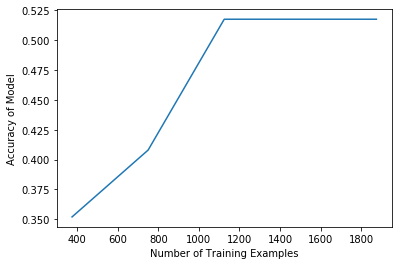

In [64]:
x = []
y = []
for i in range(PAGE_COUNT):
    x.append(int(math.floor((i+1)*500*(1-TEST_SIZE))))
    y.append(train_predict_report(df[0:(i+1)*500], print_info=False))
print('\n',x,y)
plt.plot(x,y)
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy of Model');

In [65]:
train_predict_report

<function __main__.train_predict_report>

In [0]:
import pickle

In [0]:
pickle.dump(train_predict_report, open( "model.pkl", "wb" ) )